# E-Challenge Machine Learning Edition 2021

##  A Predictive Maintenance Workflow by

## VESTA

* Guaman Diego
* Jumbo Ivannova
* Silva Kevin

Although this algorithm is unsupervised, we use the TRAIN data to have a reference on how to clean the data and configure the algorithm parameters.

### DATA PRE PROCESSING: TRAIN 

In this script we are processing all data-train files to obtained one dataset unified, cleaned and reduced to use in the predictive algorithm

* Import libraries 

In [ ]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import os
import pprint
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
!pip install chart_studio
import chart_studio.plotly as py
import plotly.express as px
import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
cf.go_offline()
from tqdm import tqdm 
tqdm.pandas()

* Initial settings

In [ ]:
pp = pprint.PrettyPrinter(indent=4)
# new dataframe in blank use in dates_files,
# frequency_files and production_files
datad = pd.DataFrame()
dataf = pd.DataFrame()
datap = pd.DataFrame()

* Find path data train file

In [ ]:
# To evaluate this notebook we import the data from Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = "/content/drive/MyDrive/e-challenge ML/Structured Data/Train/"

files = os.listdir(path)
#pp.pprint(files)

dataf = pd.read_csv(path+"/high_freq_2019.csv")
datap = pd.read_csv(path+"/production_train.csv")

for file in tqdm(files):
    if file.startswith("202"):
        temp = pd.read_csv(path+file)
        datad = pd.concat([datad,temp], axis=0)

100%|██████████| 19/19 [00:36<00:00,  1.91s/it]


* Well_ID commons in datasets

In [ ]:
# Get the wells from each dataset
well_id1 = datad["WELL_ID"].unique().tolist()
well_id2 = dataf["WELL_ID"].unique().tolist()
well_id3 = datap["WELL_ID"].unique().tolist()

common_elements = set(well_id1) & set(well_id2) & set(well_id3)
print("There are "+str(len(common_elements))+" commons wells in all datasets")

elements_delete_datad = set(well_id1)-set(common_elements)
elements_delete_dataf = set(well_id2)-set(common_elements)

There are 76 commons wells in all datasets


* Remove non-common wells in the dataf

In [ ]:
elements_delete_dataf = list(elements_delete_dataf)
for e in elements_delete_dataf:
    temp = dataf[dataf["WELL_ID"] == e].index
    dataf = dataf.drop(temp, axis=0)

print(dataf.shape, "&", len(dataf["WELL_ID"].unique().tolist()))

(18197, 13) & 76


* Add common wells in the datad

In [ ]:
common_elements = list(common_elements)
i = 0
data_temp = pd.DataFrame()
for c in tqdm(common_elements):
    temp = datad[datad["WELL_ID"] == c]
    data_temp = pd.concat([data_temp, temp], axis=0)
    i += 1

100%|██████████| 76/76 [01:53<00:00,  1.49s/it]


In [ ]:
print(data_temp.shape, "&",len(data_temp["WELL_ID"].unique().tolist()))

(6924909, 13) & 76


####  * After some analysis and data visualization we concluded that production dataset generate many NaN values because the dates columns between all datasets these do not match. The information obtained if merged was the less

* Join press_intk and press_int data_frequency same with temp_intk and temp_int

In [ ]:
# fill NaN between "PRESS_INT" and "PRESS_INTK" to leave just one column
dataf["PRESS_INT"] = dataf["PRESS_INT"].fillna(dataf["PRESS_INTK"])
dataf["TEMP_INT"] = dataf["TEMP_INT"].fillna(dataf["TEMP_INTK"])

In [ ]:
#Verified NaN percentage in dataset
NaN_data = dataf.isna().sum()
percentage = [np.round(100*i/len(dataf), 2) for i in NaN_data]
pd.DataFrame([dataf.columns.values,percentage]).T.rename(columns={0:'Features', 1:'% NaN'})

Features  % NaN
0       WELL_ID      0
1          DATE      0
2       CURRENT      0
3    PRESS_DESC      0
4     FREQUENCY      0
5     PRESS_INT      0
6      TEMP_INT      0
7      TEMP_MOT      0
8      OUT_VOLT      0
9     VIBRATION      0
10   PRESS_INTK      0
11    TEMP_INTK      0
12  WellFailure  99.79

* One dataset "data" that join dataf and data_temp

In [ ]:
data = pd.concat([dataf, data_temp], axis=0)

print(data.shape)

(6943106, 13)


In [ ]:
NaN_data = data.isna().sum()
percentage = [np.round(100*i/len(data), 2) for i in NaN_data]
pd.DataFrame([data.columns.values,percentage]).T.rename(columns={0:'Features', 1:'% NaN'})

Features  % NaN
0       WELL_ID      0
1          DATE      0
2       CURRENT   7.29
3    PRESS_DESC   7.37
4     FREQUENCY   4.41
5     PRESS_INT   3.72
6      TEMP_INT   5.36
7      TEMP_MOT   4.09
8      OUT_VOLT  95.05
9     VIBRATION   7.83
10   PRESS_INTK  99.74
11    TEMP_INTK  99.74
12  WellFailure    100

* Remove useless columns

In [ ]:
data = data.drop(["PRESS_INTK", "TEMP_INTK","OUT_VOLT"], axis=1)

list(data.columns.values)

['WELL_ID',
 'DATE',
 'CURRENT',
 'PRESS_DESC',
 'FREQUENCY',
 'PRESS_INT',
 'TEMP_INT',
 'TEMP_MOT',
 'VIBRATION',
 'WellFailure']

* Convert time data to datetime format

In [ ]:
data["DATE"] = pd.to_datetime(data["DATE"], format='%Y-%m-%d %H:%M:%S')

* Data sorted by WELL_ID and DATE

In [ ]:
data = data.sort_values(["WELL_ID", "DATE"])

data.head()

WELL_ID       DATE  CURRENT  ...  TEMP_MOT  VIBRATION  WellFailure
0  DEEPWATER-000XAR 2019-02-25    72.42  ...    281.56       0.17          NaN
1  DEEPWATER-000XAR 2019-02-26    72.77  ...    281.09       0.15          NaN
2  DEEPWATER-000XAR 2019-02-27    72.29  ...    281.55       0.15          NaN
3  DEEPWATER-000XAR 2019-03-03    72.25  ...    280.89       0.17          NaN
4  DEEPWATER-000XAR 2019-03-04    71.97  ...    280.57       0.16          NaN

[5 rows x 10 columns]

In [ ]:
#Verified NaN percentage in dataset
NaN_data = data.isna().sum()
percentage = [np.round(100*i/len(data), 2) for i in NaN_data]
pd.DataFrame([data.columns.values,percentage]).T.rename(columns={0:'Features', 1:'% NaN'})

Features % NaN
0      WELL_ID     0
1         DATE     0
2      CURRENT  7.29
3   PRESS_DESC  7.37
4    FREQUENCY  4.41
5    PRESS_INT  3.72
6     TEMP_INT  5.36
7     TEMP_MOT  4.09
8    VIBRATION  7.83
9  WellFailure   100

* Noise analysis and cleaning

In [ ]:
# variables list
wells = data["WELL_ID"].unique()
print("wells:",len(wells))
characteristics = list(data.columns.values)
characteristics.remove("WELL_ID")
characteristics.remove("DATE")
characteristics.remove("WellFailure")
#print(wells)
#print(characteristics)

wells: 76


* This analysis is per well - outliers detection

In [ ]:
df = pd.DataFrame()
well_dataset = pd.DataFrame()
Q1 = 0.15
Q3 = 0.85

# noise value change to NaNs values

for w in tqdm(wells):
    well_dataset = data[data["WELL_ID"] == w]
    
    for c in characteristics:
        if c == "VIBRATION":
            well_dataset.loc[well_dataset[c] > 10, c] = np.nan
            well_dataset.loc[well_dataset[c] < 0, c] = np.nan
        else:
            Qa = well_dataset[c].quantile(Q1)
            Qb = well_dataset[c].quantile(Q3)
            RIC = Qb - Qa
            sup = Qb + (2.5 * RIC)
            inf = Qa - (2.5 * RIC)
            
            well_dataset.loc[well_dataset[c] >= sup, c] = np.nan
            well_dataset.loc[well_dataset[c] <= inf, c] = np.nan
    
    df = pd.concat([df,well_dataset], axis=0)

100%|██████████| 76/76 [01:10<00:00,  1.08it/s]


In [ ]:
# Normalized Nan values to ffill or bfill values
df["WellFailure"] = df["WellFailure"].fillna("normal")
df = df.fillna(method='bfill')
df = df.fillna(method='ffill')

In [ ]:
#Verified NaN percentage in dataset
NaN_data = df.isna().sum()
percentage = [np.round(100*i/len(df), 2) for i in NaN_data]
pd.DataFrame([df.columns.values,percentage]).T.rename(columns={0:'Features', 1:'% NaN'})

Features % NaN
0      WELL_ID     0
1         DATE     0
2      CURRENT     0
3   PRESS_DESC     0
4    FREQUENCY     0
5    PRESS_INT     0
6     TEMP_INT     0
7     TEMP_MOT     0
8    VIBRATION     0
9  WellFailure     0

In [ ]:
df["WellFailure"].value_counts()

normal        6943020
yes                68
Manual off         18
Name: WellFailure, dtype: int64

* Resampling

In [ ]:
man_resampling=pd.DataFrame()
yes_resampling=pd.DataFrame()

In [ ]:
#The range used was only setted for an uniform values between the yes and Manual off events, these values could variate
for i in tqdm(range(1, 100)):
    yes_resampling=pd.concat([yes_resampling, df[df["WellFailure"]=="yes"]], axis=0)
for j in tqdm(range(1, 400)):
     man_resampling=pd.concat([man_resampling, df[df["WellFailure"]=="Manual off"]], axis=0)

100%|██████████| 399/399 [02:26<00:00,  2.72it/s]


In [ ]:
#Merged the yes and Manual off events with the "normal" data
df_train_final=pd.concat([df[df["WellFailure"]=="normal"],man_resampling,yes_resampling], axis=0)
df_train_final=df_train_final.sort_values(["WELL_ID","DATE"])

df_train_final["WellFailure"].value_counts()

normal        6943020
Manual off       7182
yes              6732
Name: WellFailure, dtype: int64

Now we get the statisticians just with the events, i.e., "yes" and "Manual off" . We will use only part of the final dataset limited at the maximum values of these statisticians ("CURRENT","PRESS_DESC", "FREQUENCY", "PRESS_INT", "TEMP_INT", "TEMP_MOT", "VIBRATION"), these values will be used in the data test too

In [ ]:
df_yes_man=df_train_final[df_train_final["WellFailure"]!="normal"]
df_yes_man.describe()

CURRENT    PRESS_DESC  ...      TEMP_MOT     VIBRATION
count  13914.000000  13914.000000  ...  13914.000000  13914.000000
mean      30.943144   3129.870497  ...    246.124958      0.166245
std       17.717202   1595.985242  ...    101.894947      0.664219
min        0.000000   -145.040000  ...     -0.000002      0.000000
25%       20.000000   3145.030000  ...    232.300000      0.000000
50%       30.000000   3831.110000  ...    268.299990      0.000000
75%       43.400002   4167.890000  ...    283.840000      0.190000
max       84.000000   6833.600000  ...    655.799980      7.310000

[8 rows x 7 columns]

In [ ]:
current=df_yes_man.describe().loc["max",'CURRENT']
press_desc=df_yes_man.describe().loc["max",'PRESS_DESC']
frequency=df_yes_man.describe().loc["max",'FREQUENCY']
press_int=df_yes_man.describe().loc["max",'PRESS_INT']
temp_int=df_yes_man.describe().loc["max",'TEMP_INT']
temp_mot=df_yes_man.describe().loc["max",'TEMP_MOT']
vibration=df_yes_man.describe().loc["max",'VIBRATION']

In [ ]:
df_train=df_train_final[(df_train_final["CURRENT"]<=current) & (df_train_final['PRESS_DESC']<=press_desc) & (df_train_final['FREQUENCY']<=frequency) & (df_train_final['PRESS_INT']<=press_int) & (df_train_final['TEMP_INT']<=temp_int) & (df_train_final['TEMP_MOT']<=temp_mot) & (df_train_final['VIBRATION']<=vibration)]

* Rounds up and remove negative values

In [ ]:
df_train=round(df_train,2)

df_train.iloc[:,2:9]=df_train.iloc[:,2:9].where(df_train.iloc[:,2:9]>=0, 0)

### TRAIN DATASET PREDICTION

Graph function

In [ ]:
def Graficar(well):
    well.iplot()

Due to prediction is per well, each one will be filtered.

In [ ]:
df_train["WELL_ID"].value_counts(10)

DEEPWATER-TXV4MX    0.036095
DEEPWATER-A5W4QG    0.035207
DEEPWATER-RDAYRK    0.033946
DEEPWATER-QMGS25    0.026715
DEEPWATER-EKA0CA    0.024590
                      ...   
DEEPWATER-LQB3RR    0.000552
DEEPWATER-D4EH50    0.000479
DEEPWATER-WHXTPD    0.000285
DEEPWATER-34JETX    0.000102
DEEPWATER-BSCH3H    0.000075
Name: WELL_ID, Length: 76, dtype: float64

In [ ]:
well_train = df_train[df_train["WELL_ID"]=="DEEPWATER-3FD330"].set_index("DATE")

well_train[well_train["WellFailure"]!="normal"]

WELL_ID  CURRENT  ...  VIBRATION  WellFailure
DATE                                            ...                        
2020-01-05 00:05:31  DEEPWATER-3FD330     56.0  ...        0.6   Manual off
2020-01-05 00:05:31  DEEPWATER-3FD330     56.0  ...        0.6   Manual off
2020-01-05 00:05:31  DEEPWATER-3FD330     56.0  ...        0.6   Manual off
2020-01-05 00:05:31  DEEPWATER-3FD330     56.0  ...        0.6   Manual off
2020-01-05 00:05:31  DEEPWATER-3FD330     56.0  ...        0.6   Manual off
...                               ...      ...  ...        ...          ...
2020-01-05 00:05:31  DEEPWATER-3FD330     56.0  ...        0.6   Manual off
2020-01-05 00:05:31  DEEPWATER-3FD330     56.0  ...        0.6   Manual off
2020-01-05 00:05:31  DEEPWATER-3FD330     56.0  ...        0.6   Manual off
2020-01-05 00:05:31  DEEPWATER-3FD330     56.0  ...        0.6   Manual off
2020-01-05 00:05:31  DEEPWATER-3FD330     56.0  ...        0.6   Manual off

[399 rows x 9 columns]

In [ ]:
well_train = well_train.drop(["WELL_ID","WellFailure"], axis=1)

x_train = well_train.values # to numpy array

In [ ]:
clf_train = IsolationForest(contamination=0.5, n_estimators=100)
predictions_train = clf_train.fit_predict(x_train) 
dec_fun_train = clf_train.decision_function(x_train)
well_train['level'] = dec_fun_train #New column with the anomaly level

In [ ]:
Graficar(well_train["level"]) #Predictions graph

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
#Filter anomalies per level
a=0 #ultimos
well_train[well_train["level"]==a]

CURRENT  PRESS_DESC  FREQUENCY  ...  TEMP_MOT  VIBRATION  level
DATE                                                 ...                            
2021-03-14 23:05:04     57.0      3638.0       50.0  ...     277.0        0.0    0.0
2021-03-15 00:23:17     57.0      3638.0       50.0  ...     277.0        0.0    0.0
2021-03-15 00:24:26     57.0      3638.0       50.0  ...     277.0        0.0    0.0
2021-03-15 00:25:35     57.0      3638.0       50.0  ...     277.0        0.0    0.0
2021-03-15 00:26:44     57.0      3638.0       50.0  ...     277.0        0.0    0.0
...                      ...         ...        ...  ...       ...        ...    ...
2021-03-22 05:30:29     57.0      3638.0       50.0  ...     277.0        0.0    0.0
2021-03-22 06:23:24     57.0      3638.0       50.0  ...     277.0        0.0    0.0
2021-03-22 07:16:20     57.0      3638.0       50.0  ...     277.0        0.0    0.0
2021-03-23 04:05:42     57.0      3638.0       50.0  ...     277.0        0.0    0.0
2021-04-01 02:59:50     57.0      3638.0       50.0  ...     277.0        0.0    0.0

[159 rows x 8 columns]

In [ ]:
#Filter anomalies per level
b=0.1#0.15 ultimos
well_train[well_train["level"]<-b]

CURRENT  PRESS_DESC  ...  VIBRATION     level
DATE                                      ...                     
2019-02-25 00:00:00     56.0     3595.59  ...       0.77 -0.279081
2019-02-26 00:00:00     56.0     3594.45  ...       0.76 -0.279081
2019-02-27 00:00:00     56.0     3593.95  ...       0.73 -0.276710
2019-02-28 00:00:00     56.0     3593.17  ...       0.71 -0.276710
2019-03-01 00:00:00     56.0     3592.43  ...       0.71 -0.276710
...                      ...         ...  ...        ...       ...
2021-05-25 06:59:46     58.0     3640.00  ...       0.00 -0.107316
2021-05-25 07:53:28     58.0     3640.00  ...       0.00 -0.107316
2021-05-25 07:54:38     58.0     3640.00  ...       0.00 -0.107316
2021-05-25 08:43:40     59.0     3639.00  ...       0.00 -0.113869
2021-05-25 09:17:30     58.0     3639.00  ...       0.00 -0.104902

[16779 rows x 8 columns]

_____________________________________________________________________________________________________________________________

### DATA PRE PROCESSING: TEST

In [ ]:
path2 = "Data/Test/"

In [ ]:
files2 = os.listdir(path2)
#pp.pprint(files2)

In [ ]:
dataf2 = pd.read_csv(path2+"high_freq_2019.csv")
datad2 = pd.DataFrame()

for file in files2:
    if file.startswith("202"):
        temp = pd.read_csv(path2+file)
        datad2 = pd.concat([datad2,temp], axis=0)

In [ ]:
dataf2.head()

WELL_ID        DATE  CURRENT  PRESS_DESC  FREQUENCY  PRESS_INT  \
0  DEEPWATER-0RCI25  2019-02-25    59.14     4112.53      53.96        NaN   
1  DEEPWATER-0RCI25  2019-02-26    59.03     4064.19      53.96        NaN   
2  DEEPWATER-0RCI25  2019-02-27    59.00     4055.58      53.97        NaN   
3  DEEPWATER-0RCI25  2019-02-28    59.08     4075.40      53.97        NaN   
4  DEEPWATER-0RCI25  2019-03-01    59.00     4049.52      53.96        NaN   

   TEMP_INT  TEMP_MOT  OUT_VOLT  VIBRATION  PRESS_INTK  TEMP_INTK  WellFailure  
0       NaN    274.98       0.0        0.0         0.0      226.2          NaN  
1       NaN    275.91       0.0        0.0         0.0      226.2          NaN  
2       NaN    275.96       0.0        0.0         0.0      226.2          NaN  
3       NaN    275.78       0.0        0.0         0.0      226.2          NaN  
4       NaN    276.10       0.0        0.0         0.0      226.2          NaN

In [ ]:
dataf2["PRESS_INT"] = dataf2["PRESS_INT"].fillna(dataf2["PRESS_INTK"])
dataf2["TEMP_INT"] = dataf2["TEMP_INT"].fillna(dataf2["TEMP_INTK"])

* Obtain one dataset "data_temp2" that join dataf2 and datad2

In [ ]:
# data_temp2 = pd.concat([dataf2, datad2], axis=0)

In [ ]:
# Import Blind Data from Google Drive

!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1fnNAiJYEI_R2hyeCiRgb6diIfpFB0KG9' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1fnNAiJYEI_R2hyeCiRgb6diIfpFB0KG9" -O blind.csv && rm -rf /tmp/cookies.txt
data_temp2  = pd.read_csv('blind.csv')

data_temp2["PRESS_INT"] = data_temp2["PRESS_INT"].fillna(data_temp2["PRESS_INTK"])
data_temp2["TEMP_INT"] = data_temp2["TEMP_INT"].fillna(data_temp2["TEMP_INTK"])

In [ ]:
NaN_data = data_temp2.isna().sum()
percentage = [np.round(100*i/len(data_temp2), 2) for i in NaN_data]
pd.DataFrame([data_temp2.columns.values,percentage]).T.rename(columns={0:'Features', 1:'% NaN'})

Features  % NaN
0       WELL_ID      0
1          DATE      0
2       CURRENT   5.81
3    PRESS_DESC   3.95
4     FREQUENCY   4.58
5     PRESS_INT   2.46
6      TEMP_INT   1.86
7      TEMP_MOT   1.32
8      OUT_VOLT  93.51
9     VIBRATION   2.92
10   PRESS_INTK  99.71
11    TEMP_INTK  99.71
12  WellFailure    100

* Remove useless columns

In [ ]:
data_temp2 = data_temp2.drop(["PRESS_INTK", "TEMP_INTK","OUT_VOLT"], axis=1)

In [ ]:
NaN_data = data_temp2.isna().sum()
percentage = [np.round(100*i/len(data_temp2), 2) for i in NaN_data]
pd.DataFrame([data_temp2.columns.values,percentage]).T.rename(columns={0:'Features', 1:'% NaN'})

Features % NaN
0      WELL_ID     0
1         DATE     0
2      CURRENT  5.81
3   PRESS_DESC  3.95
4    FREQUENCY  4.58
5    PRESS_INT  2.46
6     TEMP_INT  1.86
7     TEMP_MOT  1.32
8    VIBRATION  2.92
9  WellFailure   100

In [ ]:
data_temp2["DATE"] = pd.to_datetime(data_temp2["DATE"], format='%Y-%m-%d %H:%M:%S')

* Noise analysis and cleaning in train dataframe

In [ ]:
# variables list
wells2 = data_temp2["WELL_ID"].unique()
print("wells:",len(wells2))
characteristics2 = list(data_temp2.columns.values)
characteristics2.remove("WELL_ID")
characteristics2.remove("DATE")
characteristics2.remove("WellFailure")
#print(wells2)
#print(characteristics2)

wells: 10


* Characteristics graphs per well

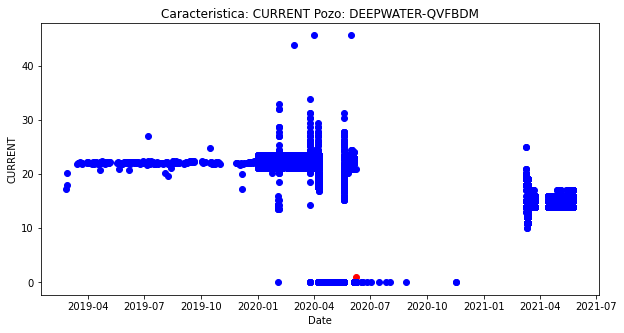

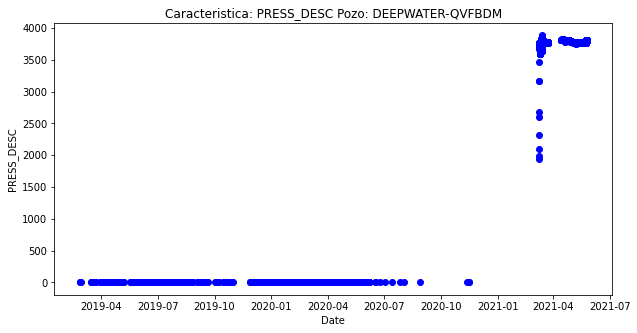

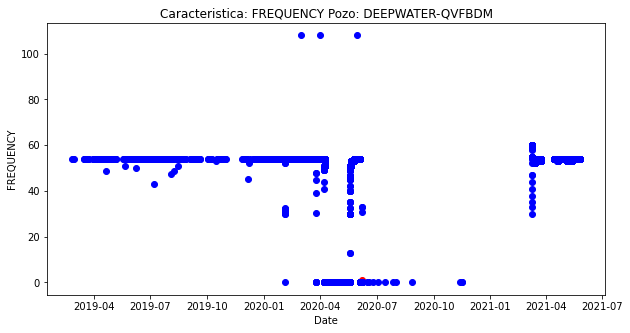

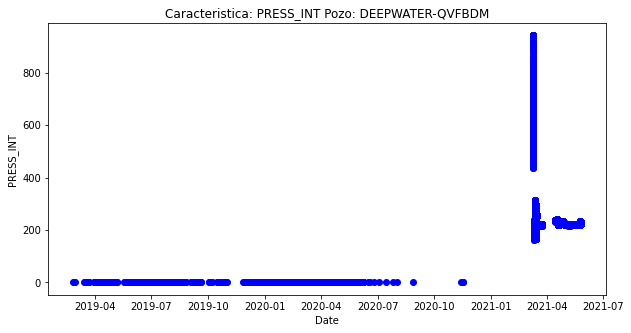

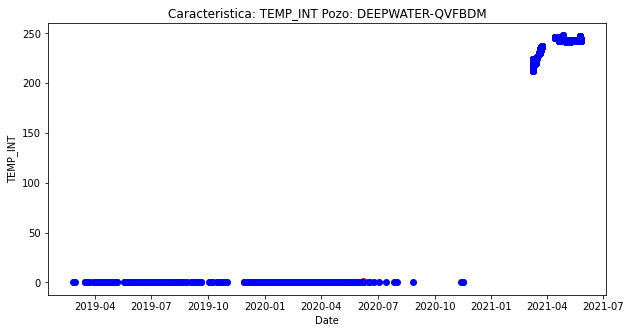

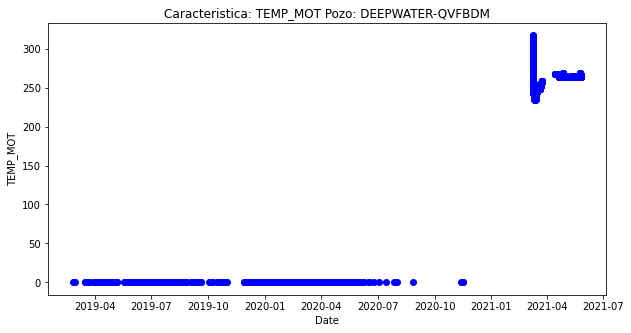

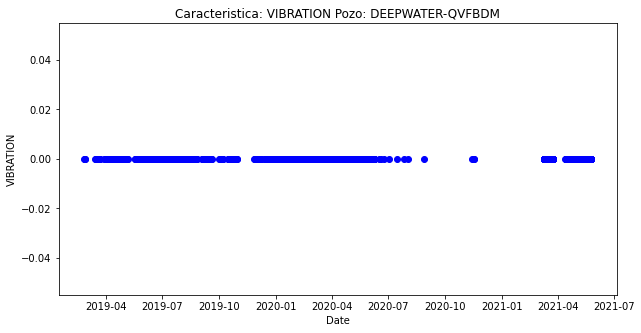

In [ ]:
from time import sleep
p = wells2[3]

for c in characteristics2:
    figure_general = data_temp2[(data_temp2["WELL_ID"] == p)]
    figure_general['WellFailure'] = figure_general['WellFailure'].replace(to_replace={'yes':1,'Manual Off':2})
    plt.figure(figsize=(10,5))        
    if c=="VIBRATION":
        plt.scatter(x=figure_general["DATE"], y=figure_general[c], color="b")
    else:
        plt.scatter(x=figure_general["DATE"], y=figure_general["WellFailure"], color="r")
        plt.scatter(x=figure_general["DATE"], y=figure_general[c], color="b")
    plt.title("Caracteristica: "+c+" Pozo: "+p)
    plt.ylabel(c)
    plt.xlabel("Date")
    plt.show()
    sleep(1)

* Outliers detection in test dataframe "data_temp2"

In [ ]:
data_test = pd.DataFrame()
well_dataset = pd.DataFrame()
Q1 = 0.10
Q3 = 0.90

# noise value change to NaNs values

for w in tqdm(wells2):
    well_dataset = data_temp2[data_temp2["WELL_ID"] == w]
    
    for c in characteristics:
        if c == "VIBRATION":
            well_dataset.loc[well_dataset[c] > 10, c] = np.nan
            well_dataset.loc[well_dataset[c] < 0, c] = np.nan
        else:
            Qa = well_dataset[c].quantile(Q1)
            Qb = well_dataset[c].quantile(Q3)
            RIC = Qb - Qa
            sup = Qb + (2.5 * RIC)
            inf = Qa - (2.5 * RIC)
            
            well_dataset.loc[well_dataset[c] >= sup, c] = np.nan
            well_dataset.loc[well_dataset[c] <= inf, c] = np.nan
    
    data_test = pd.concat([data_test,well_dataset], axis=0)

100%|██████████| 10/10 [00:01<00:00,  7.73it/s]


In [ ]:
NaN_data = data_test.isna().sum()
percentage = [np.round(100*i/len(data_test), 2) for i in NaN_data]
pd.DataFrame([data_test.columns.values,percentage]).T.rename(columns={0:'Features', 1:'% NaN'})

Features  % NaN
0      WELL_ID      0
1         DATE      0
2      CURRENT   8.77
3   PRESS_DESC   8.42
4    FREQUENCY  22.79
5    PRESS_INT   4.48
6     TEMP_INT   7.35
7     TEMP_MOT    5.8
8    VIBRATION   3.08
9  WellFailure    100

* Compare results of data filter and previous graphics in one well 

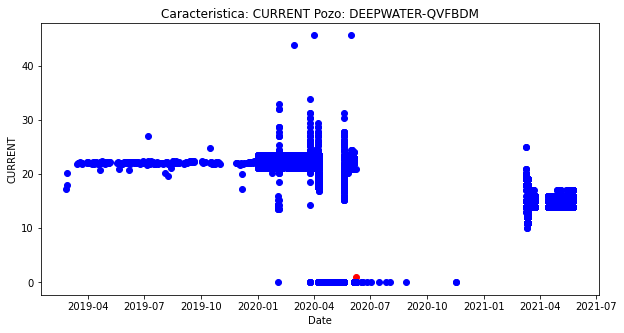

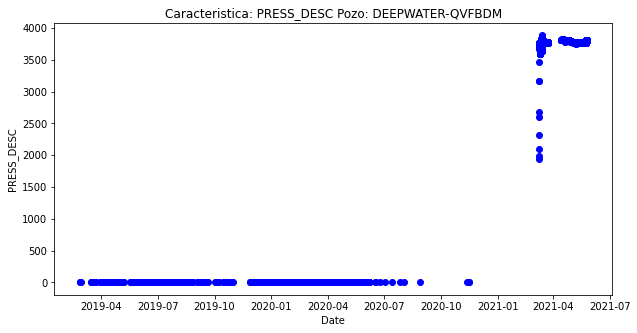

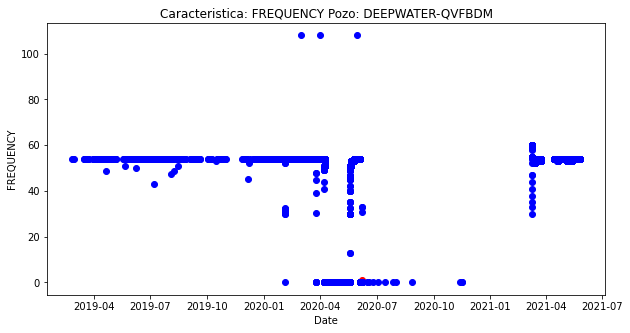

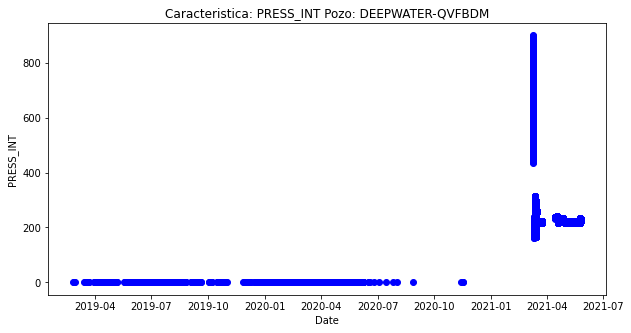

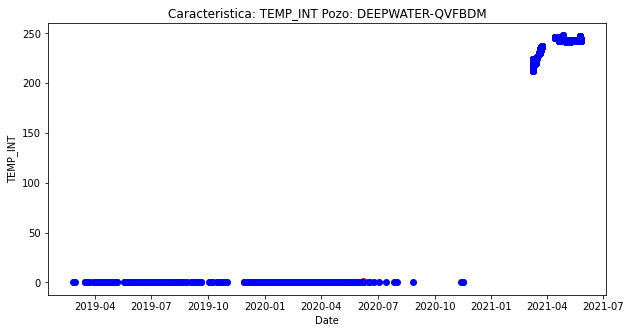

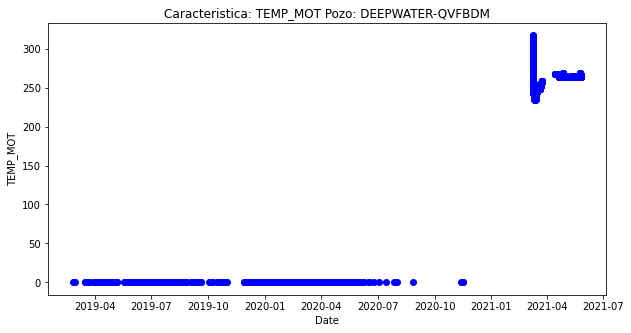

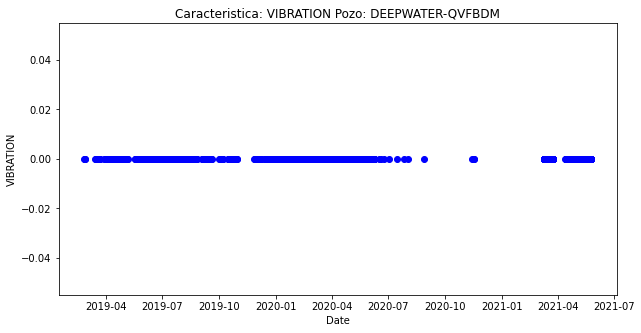

In [ ]:
p = wells2[3]

for c in characteristics2:
    figure_general = data_test[(data_test["WELL_ID"] == p)]
    figure_general['WellFailure'] = figure_general['WellFailure'].replace(to_replace={'yes':1,'Manual Off':2})
    plt.figure(figsize=(10,5))        
    if c=="VIBRATION":
        plt.scatter(x=figure_general["DATE"], y=figure_general[c], color="b")
    else:
        plt.scatter(x=figure_general["DATE"], y=figure_general["WellFailure"], color="r")
        plt.scatter(x=figure_general["DATE"], y=figure_general[c], color="b")
    plt.title("Caracteristica: "+c+" Pozo: "+p)
    plt.ylabel(c)
    plt.xlabel("Date")
    plt.show()
    sleep(1)

In [ ]:
# Normalized Nan values to ffill or bfill values
data_test["WellFailure"] = data_test["WellFailure"].fillna(0)
data_test = data_test.fillna(method='bfill')
data_test = data_test.fillna(method='ffill')

In [ ]:
NaN_data = data_test.isna().sum()
percentage = [np.round(100*i/len(data_test), 2) for i in NaN_data]
pd.DataFrame([data_test.columns.values,percentage]).T.rename(columns={0:'Features', 1:'% NaN'})

Features % NaN
0      WELL_ID     0
1         DATE     0
2      CURRENT     0
3   PRESS_DESC     0
4    FREQUENCY     0
5    PRESS_INT     0
6     TEMP_INT     0
7     TEMP_MOT     0
8    VIBRATION     0
9  WellFailure     0

In [ ]:
final_data_test=data_test

final_data_test["WellFailure"] = final_data_test["WellFailure"].replace(0, "normal")

final_data_test = final_data_test.sort_values(["WELL_ID", "DATE"])

In [ ]:
final_data_test=round(final_data_test,2)
final_data_test.iloc[:,2:9]=final_data_test.iloc[:,2:9].where(final_data_test.iloc[:,2:9]>=0, 0)

In [ ]:
df_test=final_data_test[(final_data_test["CURRENT"]<=current) & (final_data_test['PRESS_DESC']<=press_desc) & (final_data_test['FREQUENCY']<=frequency) & (final_data_test['PRESS_INT']<=press_int) & (final_data_test['TEMP_INT']<=temp_int) & (final_data_test['TEMP_MOT']<=temp_mot) & (final_data_test['VIBRATION']<=vibration)]

In [ ]:
df_test

WELL_ID                DATE  ...  VIBRATION  WellFailure
506503  DEEPWATER-2ZLRT1 2019-02-25 00:00:00  ...       0.19       normal
506504  DEEPWATER-2ZLRT1 2019-02-26 00:00:00  ...       0.19       normal
506505  DEEPWATER-2ZLRT1 2019-02-27 00:00:00  ...       0.19       normal
506506  DEEPWATER-2ZLRT1 2019-02-28 00:00:00  ...       0.18       normal
506507  DEEPWATER-2ZLRT1 2019-03-01 00:00:00  ...       0.20       normal
...                  ...                 ...  ...        ...          ...
388958  DEEPWATER-XWF4WL 2021-05-25 07:59:01  ...       0.00       normal
388959  DEEPWATER-XWF4WL 2021-05-25 08:19:01  ...       0.00       normal
388960  DEEPWATER-XWF4WL 2021-05-25 08:38:58  ...       0.00       normal
388961  DEEPWATER-XWF4WL 2021-05-25 08:59:02  ...       0.00       normal
388962  DEEPWATER-XWF4WL 2021-05-25 09:19:02  ...       0.00       normal

[786096 rows x 10 columns]

### TEST DATASET PREDICTION

New data frame where the prediction per well will be saved and event

In [ ]:
prediction=pd.DataFrame()

Man=pd.DataFrame(["Manual off"],columns=["WellFailure"])
yes=pd.DataFrame(["yes"],columns=["WellFailure"])

#### WELL ORDER FOR PREDICTION

In [ ]:
blind_wells = ['DEEPWATER-O4AWBU',
              'DEEPWATER-3XFTSJ',
              'DEEPWATER-QVFBDM',
              'DEEPWATER-XWF4WL',
              'DEEPWATER-LIS23E',
              'DEEPWATER-OUFAML',
              'DEEPWATER-M3XG2L',
              'DEEPWATER-2ZLRT1',
              'DEEPWATER-EHFSV4']

Due to prediction is per well, each one will be filtered.

In [ ]:
for i in blind_wells:
  well_test = df_test[df_test["WELL_ID"]==i].set_index("DATE")
  name =well_test.loc[:,"WELL_ID"].unique().tolist()
  well_test = well_test.drop(["WELL_ID","WellFailure"], axis=1)

  x_test = well_test.values # to numpy array
  clf_test = IsolationForest(contamination=0.1, n_estimators=100)
  predictions_test = clf_test.fit_predict(x_test) 
  dec_fun_test = clf_test.decision_function(x_test)
  well_test['level'] = dec_fun_test #New column with the anomaly level  
  c=0 
  d=0.1

  #Assuming there will always be "yes" event, i.e. b
  # If Manual off does not exits, i.e. a=0 does not exits:
  if len(well_test[well_test["level"]==c].index.to_list())==0:
      well_1=well_test.reset_index()
      pred=well_1.iloc[[np.max(well_1[well_1["level"]<-d].index)],:1]  
      well_prd = pd.concat([pd.DataFrame(name, columns=["WELL_ID"]), pred.reset_index(drop=True),yes], axis=1)


  # If Manual off does exits, we choose the earlier Date:
  if len(well_test[well_test["level"]==c].index.to_list())!=0:
      
      well_1=well_test.reset_index()
    
      # Manual off earlier
      if well_1[well_1["level"]==c].index[0]<np.max(well_1[well_1["level"]<-d].index):  
          pred=well_1.iloc[[np.max(well_1[well_1["level"]==c].index)],:1]  
          well_prd = pd.concat([pd.DataFrame(name, columns=["WELL_ID"]), pred.reset_index(drop=True),Man], axis=1)
    
      # Yes earlier
      else:
          
          well_prd = pd.concat([pd.DataFrame(name, columns=["WELL_ID"]), pred.reset_index(drop=True),yes], axis=1)
  
  prediction = pd.concat([prediction,well_prd], axis=0)

In [ ]:
prediction = prediction.reset_index().drop('index',1)
prediction

WELL_ID                DATE WellFailure
0  DEEPWATER-O4AWBU 2021-05-25 00:19:32         yes
1  DEEPWATER-3XFTSJ 2021-02-25 19:39:17         yes
2  DEEPWATER-QVFBDM 2020-11-16 07:51:06  Manual off
3  DEEPWATER-XWF4WL 2020-06-26 13:36:00  Manual off
4  DEEPWATER-LIS23E 2020-04-24 10:29:02         yes
5  DEEPWATER-OUFAML 2021-04-02 08:31:06         yes
6  DEEPWATER-M3XG2L 2020-03-21 20:40:00  Manual off
7  DEEPWATER-2ZLRT1 2020-06-24 08:07:13  Manual off
8  DEEPWATER-EHFSV4 2021-04-26 13:07:58  Manual off

#<b> Blind Scoring

In [ ]:
from sklearn.metrics import accuracy_score
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1yqJnu5Liti62EAWoem5wee472biMrTEf' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1yqJnu5Liti62EAWoem5wee472biMrTEf" -O blind_result.csv && rm -rf /tmp/cookies.txt

In [ ]:
blind_result = pd.read_csv('blind_result.csv',parse_dates=[1])
blind_result 

WELL_ID                DATE WellFailure
0  DEEPWATER-O4AWBU 2020-08-23 00:00:03         yes
1  DEEPWATER-3XFTSJ 2020-12-15 00:19:05         yes
2  DEEPWATER-QVFBDM 2020-06-07 00:04:37         yes
3  DEEPWATER-XWF4WL 2021-04-12 00:18:57         yes
4  DEEPWATER-LIS23E 2020-04-02 00:00:00         yes
5  DEEPWATER-OUFAML 2021-04-01 00:01:30         yes
6  DEEPWATER-M3XG2L 2020-02-28 00:00:00         yes
7  DEEPWATER-2ZLRT1 2020-08-13 00:19:02         yes
8  DEEPWATER-EHFSV4 2021-05-01 00:01:51         yes

In [ ]:
truth = blind_result.copy()
pred = result.copy()

if pred.isnull().sum().sum() == 0:

####################################################################################

    if (truth['WELL_ID'] == pred['WELL_ID']).all() and len(np.union1d(truth.keys(),pred.keys()))==3:
        score = pd.merge(truth,pred,on=['WELL_ID'],suffixes=('_true','_pred'),how='left')
        
        ############################ GRADE DATE PREDICTION #####################################
        date_scores = []

        for i in score.index:
            
            timedelta = (pd.Timestamp(score.iloc[i,1]) - pd.Timestamp(score.iloc[i,3])).days
            if timedelta < 0:
                timedelta = (pd.Timestamp(score.iloc[i,3]) - pd.Timestamp(score.iloc[i,1])).days
                
            if timedelta == 0:
                date_scores.append(1)        
            elif timedelta == 1:
                date_scores.append(0.9) 
            elif timedelta == 2:
                date_scores.append(0.8)  
            elif timedelta == 3:
                date_scores.append(0.7)
            elif timedelta == 4:
                date_scores.append(0.6)
            elif timedelta == 5:
                date_scores.append(0.5)
            elif timedelta == 6:
                date_scores.append(0.4)   
            elif timedelta == 7:
                date_scores.append(0.3)                                                                
            elif timedelta == 8:
                date_scores.append(0.2)   
            elif timedelta <30:
                date_scores.append(-1)         
            else:
                date_scores.append(-3)

        date_score = np.sum(date_scores)/len(truth)

        ################################### GRADE ACCURACY PREDICTION ##########################
        failure_score = accuracy_score(score['WellFailure_true'].values,score['WellFailure_pred'].values)
        
        ##################################### FINAL SCORE ######################################
        
        final_score = round(date_score*failure_score,3)

    else:
        final_score = -999

final_score

-0.783

<h1><b> Final Score: 
<h2><b> -0.783
<h3> Tested by Felix Gallo
<h3> E-Challenge Team
<h3><B> SPE Ecuador Section

In [ ]:
import zipfile
#prediction.to_csv(r"predictions.csv",index=False)
#zipfile.ZipFile(r"predictions.zip", mode="w").write("predictions.csv")

Final conclusions: 

During the analysis of the data in each well, it was observed that there were similar failure behaviors in periods of time that supposedly the well was in normal operation, this indicates that perhaps a failure occurs in random periods or perhaps another type of test is required. indicators.
The well location dataset was not used, because a correlation was not found between the parameters of the wells and their location.